# Projeto Udacity - Sistema de recomendações para usuários do MyAnimeList

In [2]:
from collections import defaultdict
import pandas as pd
import numpy as np
import scipy
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import surprise as sp
from surprise.model_selection import train_test_split
import time

Referências e explicações:

[Datasets utilizados](https://www.kaggle.com/azathoth42/myanimelist/version/9#_=_)

[Bíblia](https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101)

[Merges explicados](https://www.shanelynn.ie/merge-join-dataframes-python-pandas-index-1/)

[Gráficos explicados](http://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot)

[Análises de rating](https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b)

[Baseline Only](http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf)

The parameters bu and bi indicate the observed deviations of user u and item i,
respectively, from the average. For example, suppose that we want a baseline
estimate for the rating of the movie Titanic by user Joe. Now, say that the
average rating over all movies, μ, is 3.7 stars. Furthermore, Titanic is better
than an average movie, so it tends to be rated 0.5 stars above the average. On
the other hand, Joe is a critical user, who tends to rate 0.3 stars lower than the
average. Thus, the baseline estimate for Titanic’s rating by Joe would be 3.9
stars by calculating 3.7 − 0.3 + 0.5. In order to estimate bu and bi one can solve
the least squares problem:

# Datasets

The datasets are mainly divided in three. One with info about the MyAnimeList customers (UsersDF) such as location, gender, birth date and so on. Another one for info about the anime, which brings data like the title of the show, what genre is it inside and even the opening themes. The last one (and also the biggest one) is all the scores that a certain user had with a show.

In [3]:
UsersDF = pd.read_csv('users_cleaned.csv')
AnimesDF = pd.read_csv('anime_cleaned.csv')
ScoresDF = pd.read_csv('animelists_cleaned.csv')

In [4]:
AnimesDF.head()

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme,duration_min,aired_from_year
0,11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,...,Fridays at Unknown,"{'Adaptation': [{'mal_id': 17207, 'type': 'man...","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Sentai Filmworks,David Production,"Comedy, Supernatural, Romance, Shounen","['""Nirvana"" by MUCC']","['#1: ""Nirvana"" by MUCC (eps 1, 11-12)', '#2: ...",24.0,2012.0
1,2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 759, 'type': 'manga...","TV Tokyo, AIC, Square Enix, Sotsu",Funimation,Gonzo,"Comedy, Parody, Romance, School, Shounen","['""Romantic summer"" by SUN&LUNAR']","['#1: ""Ashita e no Hikari (明日への光)"" by Asuka Hi...",24.0,2007.0
2,5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 101, 'type': 'manga...","TV Tokyo, Sotsu",NaN,Satelight,"Comedy, Magic, School, Shoujo","['#1: ""Minna no Tamago (みんなのたまご)"" by Shugo Cha...","['#1: ""Rottara Rottara (ロッタラ ロッタラ)"" by Buono! ...",24.0,2008.0
3,721,Princess Tutu,Princess Tutu,プリンセスチュチュ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,38,Finished Airing,...,Fridays at Unknown,"{'Adaptation': [{'mal_id': 1581, 'type': 'mang...","Memory-Tech, GANSIS, Marvelous AQL",ADV Films,Hal Film Maker,"Comedy, Drama, Magic, Romance, Fantasy","['""Morning Grace"" by Ritsuko Okazaki']","['""Watashi No Ai Wa Chiisaikeredo"" by Ritsuko ...",16.0,2002.0
4,12365,Bakuman. 3rd Season,Bakuman.,バクマン。,Bakuman Season 3,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 9711, 'type': 'mang...","NHK, Shueisha",NaN,J.C.Staff,"Comedy, Drama, Romance, Shounen","['#1: ""Moshimo no Hanashi (もしもの話)"" by nano.RIP...","['#1: ""Pride on Everyday"" by Sphere (eps 1-13)...",24.0,2012.0


In [5]:
UsersDF.head()

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
0,karthiga,2255153,3,49,1,0,0,55.091667,Female,"Chennai, India",1990-04-29 00:00:00,NaN,2013-03-03 00:00:00,2014-02-04 01:32:00,7.43,0.0,3391
1,Damonashu,37326,45,195,27,25,59,82.574306,Male,"Detroit,Michigan",1991-08-01 00:00:00,NaN,2008-02-13 00:00:00,2017-07-10 06:52:54,6.15,6.0,4903
2,bskai,228342,25,414,2,5,11,159.483333,Male,"Nayarit, Mexico",1990-12-14 00:00:00,NaN,2009-08-31 00:00:00,2014-05-12 16:35:00,8.27,1.0,9701
3,terune_uzumaki,327311,5,5,0,0,0,11.394444,Female,"Malaysia, Kuantan",1998-08-24 00:00:00,NaN,2010-05-10 00:00:00,2012-10-18 19:06:00,9.70,6.0,697
4,Bas_G,5015094,35,114,6,20,175,30.458333,Male,"Nijmegen, Nederland",1999-10-24 00:00:00,NaN,2015-11-26 00:00:00,2018-05-10 20:53:37,7.86,0.0,1847


In [6]:
ScoresDF.head()

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
0,karthiga,21,586,0000-00-00,0000-00-00,9,1,NaN,0,2013-03-03 10:52:53,NaN
1,karthiga,59,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-10 13:54:51,NaN
2,karthiga,74,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-04-27 16:43:35,NaN
3,karthiga,120,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-03 10:53:57,NaN
4,karthiga,178,26,0000-00-00,0000-00-00,7,2,0.0,0,2013-03-27 15:59:13,NaN


In [7]:
#Since InteractionsDF is a huge DF (2GB of data) I`ll only take the columns that are important for the recommendation system
ScoresDF = ScoresDF[['username', 'anime_id', 'my_score', 'my_status']]

In [8]:
#ScoresDFSampled = ScoresDF.sample(frac = 0.99, random_state = 42)
#ScoresDFSampled.head()

In [9]:
#Analysing all the possible values for the score
lower_rating = ScoresDF['my_score'].min()
upper_rating = ScoresDF['my_score'].max()
print('Range of ratings vary between: {0} to {1}'.format(lower_rating, upper_rating))

Range of ratings vary between: 0 to 10


In [10]:
#Only filtering animes in which people actually watched, are watching or are on hold as they are the most revelant for the rec sys
#RelevantScoresDF = ScoresDF[(ScoresDF['my_status'] == 1) | (ScoresDF['my_status'] == 2) | (ScoresDF['my_status'] == 3)]

In [11]:
#Counting how many relevant scores each user have done, resetting the index (so the series could become a DF again) and changing the column names
RatedsPerUser = ScoresDF['username'].value_counts().reset_index().rename(columns={"username": "animes_rated", "index": "username"})

In [12]:
RatedsPerUser = RatedsPerUser.sample(frac = 0.01, random_state = 42)

In [13]:
#Grouping users whom had the same amount of animes rated
UserRatedsAggregated = RatedsPerUser['animes_rated'].value_counts().reset_index().rename(columns={"animes_rated": "group_size", "index": "animes_rated"}).sort_values(by=['animes_rated'])
UserRatedsAggregated.head(n = 100)

,animes_rated,group_size
1,1,7
340,2,1
72,3,4
13,4,6
53,5,4
51,6,4
131,7,3
5,8,7
16,9,5
64,10,4


In [14]:
#Counting how many relevant scores each anime has, resetting the index (so the series could become a DF again) and changing the column names
RatedsPerAnime = ScoresDF['anime_id'].value_counts().reset_index().rename(columns={"anime_id": "number_of_users", "index": "anime_id"})
RatedsPerAnime.head()

,anime_id,number_of_users
0,1535,81332
1,1575,67721
2,226,64486
3,5114,63649
4,4224,63278


In [15]:
#Grouping users whom had the same amount of animes rated
AnimeRatedsAggregated = RatedsPerAnime['number_of_users'].value_counts().reset_index().rename(columns={"number_of_users": "group_size", "index": "number_of_users"}).sort_values(by=['number_of_users'])
AnimeRatedsAggregated.head(n = 30)

,number_of_users,group_size
443,1,3
24,2,11
26,3,11
21,4,12
6,5,16
17,6,13
10,7,14
8,8,16
1,9,22
2,10,21


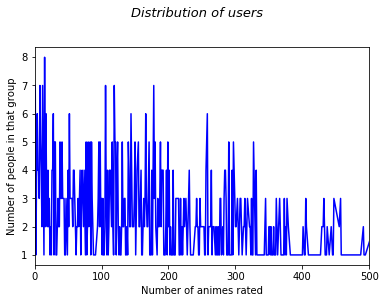

In [16]:
#As expected, most of our users have rated a lower amount of animes, but even so 
#I think we don't lose much information by excluding these customers for the user cold-start issue, so we will
#create an abirtrary cut line of only analysing users that have interacted with at least 10 animes

plt.suptitle("Distribution of users", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)
plt.plot('animes_rated', 'group_size', data = UserRatedsAggregated, color = 'blue')
plt.xlabel('Number of animes rated')
plt.ylabel('Number of people in that group')
plt.xlim(left = 0, right = 500)
plt.show()

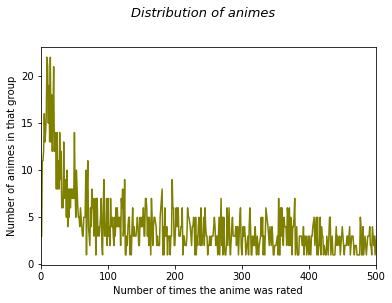

In [17]:
plt.suptitle("Distribution of animes", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)
plt.plot('number_of_users', 'group_size', data = AnimeRatedsAggregated, color = 'olive')
plt.xlabel('Number of times the anime was rated')
plt.ylabel('Number of animes in that group')
plt.xlim(left = 0, right = 500)
plt.show()

In [18]:
#Here we create another dataframe which contain only customers that have at least 10 valueable (as we filtered
#back then) ratings by merging our initial frame and the RatedsPerUser one. We also just bring the first three columns
#because it is already in the format of the library we will use

UserRatedsCutten = RatedsPerUser[RatedsPerUser['animes_rated'] >= 10]
AnimeRatedsCutten = RatedsPerAnime[RatedsPerAnime['number_of_users'] >= 10]
ScoresDFHotStart = pd.merge(ScoresDF, UserRatedsCutten, left_on = 'username', right_on = 'username', how = 'inner')
ScoresDFHotStart = pd.merge(ScoresDFHotStart, AnimeRatedsCutten, left_on = 'anime_id', right_on = 'anime_id', how = 'inner')

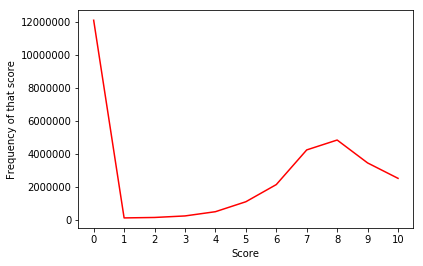

In [19]:
AnimeRates = ScoresDF['my_score'].value_counts().reset_index().sort_values('index')
AnimeRates.head(n = 10)
plt.plot('index', 'my_score', data = AnimeRates, color = 'red')
plt.xticks(np.arange(11))
plt.ticklabel_format(axis = 'y', style = 'plain')
plt.xlabel('Score')
plt.ylabel('Frequency of that score')
plt.show()

In [20]:
#Just for the record, lets analyse the pattern for the scores given by the site users

ScoresDF.count()

username     31283787
anime_id     31284030
my_score     31284030
my_status    31284030
dtype: int64

In [21]:
ScoresDFHotStart.count()

username           323043
anime_id           323043
my_score           323043
my_status          323043
animes_rated       323043
number_of_users    323043
dtype: int64

In [22]:
#ScoresDFHotStart.to_csv("Scores.csv")

In [23]:
def precision_recall_at_k(predictions, k=10, threshold= 7):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    # Predictions: Traz uma lista de 5 campos dentro de uma tupla com as seguintes infos: User_ID, Item_ID, True_ID, Est_ID, Details
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    # Cria um dicionário com a key relativa a um usuário e dois valores relacionados; a nota estimada e a real.

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k /  n_rel if n_rel != 0 else 1

    return precisions, recalls

In [24]:
reader = sp.Reader(rating_scale=(0, 10))
data = sp.Dataset.load_from_df(ScoresDFHotStart[['username', 'anime_id', 'my_score']], reader)
trainset, testset = train_test_split(data, test_size=.25)
analysis = defaultdict(list)

for algo in [sp.SVD(), sp.SlopeOne(), sp.NMF(), sp.NormalPredictor(), sp.KNNBaseline(), sp.KNNBasic(), sp.KNNWithMeans(), sp.KNNWithZScore(), sp.BaselineOnly(), sp.CoClustering()]:
    start = time.time()    
    algo.fit(trainset)
    predictions = algo.test(testset)

    rmse = sp.accuracy.rmse(predictions)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=7)
    precision_avg = sum(prec for prec in precisions.values()) / len(precisions)

    analysis[algo] = (rmse, precision_avg, time.time() - start)

print(analysis)

RMSE: 3.4147
RMSE: 3.1760
RMSE: 3.3139
RMSE: 5.0659
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 3.1403
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 3.2899
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 3.1648
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 3.1746
Estimating biases using als...
RMSE: 3.1683
RMSE: 3.2213
defaultdict(<class 'list'>, {<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x0000022701503EB8>: (3.4147435060647404, 0.7878671775223497, 17.44332456588745), <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x0000022701503240>: (3.1759599175598443, 0.905539591315452, 48.652809858322144), <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x0000022701503390>: (3.313938698081906, 0.8390166028097051, 19.258495092391968), <surprise.prediction_algorithms.random_pred.No

In [25]:
analysis_df = pd.DataFrame.from_dict(analysis, orient = 'index', columns = ['RMSE', 'Precision@10', 'Time to run (in seconds)']).reset_index()

analysis_df['Algorithm'] = ['SVD', 'SlopeOne', 'NMF', 'NormalPredictor', 'KNNBaseline', 'KNNBasic', 'KNNWithMeans', 'KNNWithZScore', 'BaselineOnly', 'CoClustering']
analysis_df = analysis_df[['Algorithm', 'RMSE', 'Precision@10', 'Time to run (in seconds)']]
analysis_df = analysis_df.sort_values(by=['Precision@10'], ascending = False)
analysis_df['RMSE^-1'] = analysis_df['RMSE'] ** -1
analysis_df.head(n = 15)

,Algorithm,RMSE,Precision@10,Time to run (in seconds),RMSE^-1
8,BaselineOnly,3.168256,0.912755,1.478014,0.315631
1,SlopeOne,3.175960,0.905540,48.652810,0.314865
4,KNNBaseline,3.140341,0.905364,21.420715,0.318437
6,KNNWithMeans,3.164804,0.900239,16.517801,0.315975
9,CoClustering,3.221266,0.877267,8.599987,0.310437
7,KNNWithZScore,3.174631,0.862931,17.558047,0.314997
2,NMF,3.313939,0.839017,19.258495,0.301756
5,KNNBasic,3.289890,0.830795,15.450656,0.303962
0,SVD,3.414744,0.787867,17.443325,0.292848
3,NormalPredictor,5.065949,0.529374,0.985336,0.197396


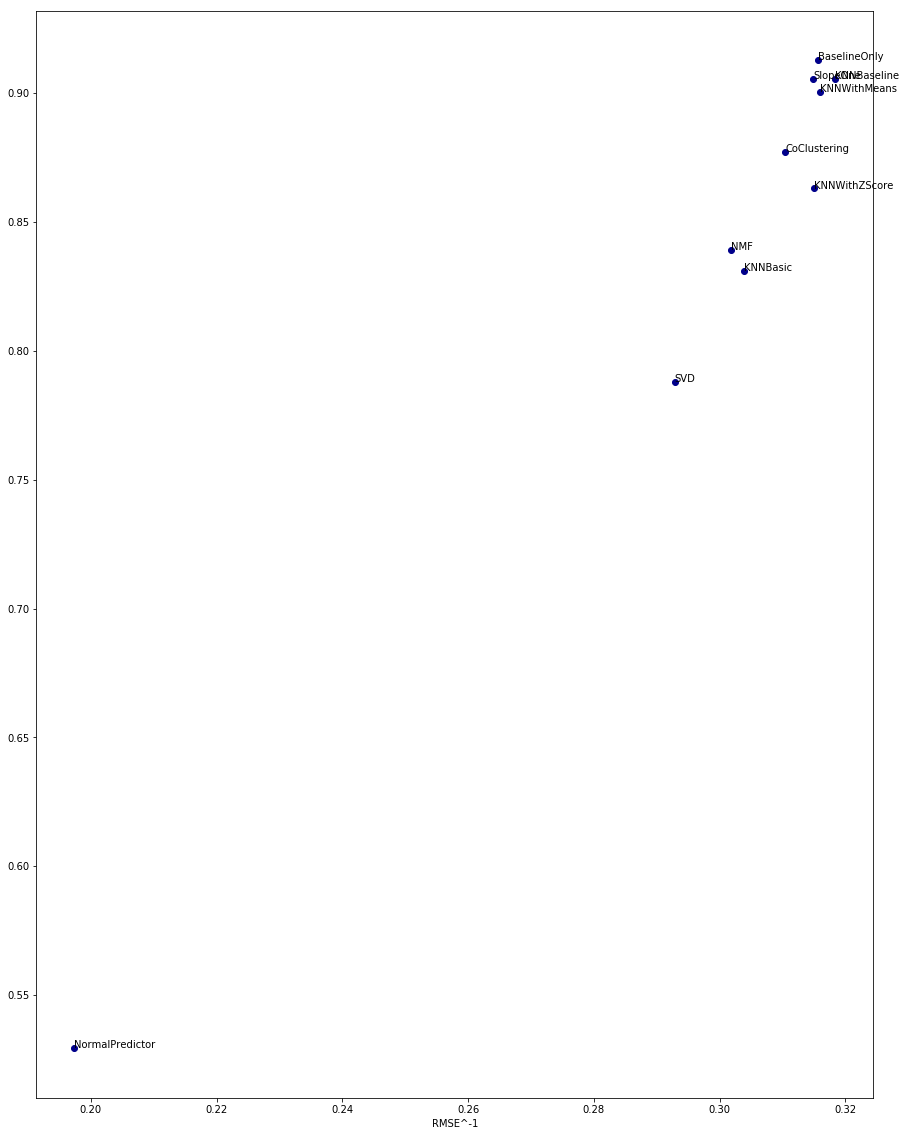

In [26]:
ax = analysis_df.set_index('RMSE^-1')['Precision@10'].plot(style='o', c = 'DarkBlue', figsize = (15, 20))

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))

label_point(analysis_df['RMSE^-1'], analysis_df['Precision@10'], analysis_df['Algorithm'], ax)

In [27]:
trainset = data.build_full_trainset()
algo = sp.BaselineOnly()
algo.fit(trainset)

testset = trainset.build_anti_testset()
predictions = algo.test(testset)

def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
last_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
last_predictions.drop('rui', inplace = True, axis = 1)
last_predictions['Iu'] = last_predictions.uid.apply(get_Iu)
last_predictions['Ui'] = last_predictions.iid.apply(get_Ui)

Estimating biases using als...


In [37]:
def bringing_first_n_values(df, uid, n=10):
    return df[df['uid'] == uid].nlargest(n, 'est')[['uid', 'iid', 'est']]

,uid,iid,est
280,SocialAwkward,30276,8.138477
283,SocialAwkward,32281,8.041673
309,SocialAwkward,26055,7.970312
753,SocialAwkward,4814,7.958905
1563,SocialAwkward,34240,7.842201
615,SocialAwkward,31964,7.837598
620,SocialAwkward,33486,7.783084
312,SocialAwkward,31933,7.717219
59,SocialAwkward,317,7.716100
751,SocialAwkward,3092,7.708418


In [38]:
bringing_first_n_values(last_predictions, 'SocialAwkward')

,uid,iid,est
280,SocialAwkward,30276,8.138477
283,SocialAwkward,32281,8.041673
309,SocialAwkward,26055,7.970312
753,SocialAwkward,4814,7.958905
1563,SocialAwkward,34240,7.842201
615,SocialAwkward,31964,7.837598
620,SocialAwkward,33486,7.783084
312,SocialAwkward,31933,7.717219
59,SocialAwkward,317,7.716100
751,SocialAwkward,3092,7.708418
